In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pandas as pd
import sklearn
# classifiers / models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston
# Feature selection
from sklearn.feature_selection import RFE

from itertools import combinations
from itertools import chain
# data
from sklearn import datasets
from sklearn.datasets import make_friedman1

# other
from sklearn.metrics import log_loss, accuracy_score
from collections import deque
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import nltk

from sklearn.feature_extraction.text import CountVectorizer


import altair as alt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

import docopt

In [2]:
docopt.__version__


'0.6.2'

In [3]:
training_data = pd.read_csv("../data/training_data.csv")
testing_data = pd.read_csv("../data/test_data.csv")

In [4]:
training_data['weekday'] = training_data['weekday'].replace(
                                {'Sunday' : 0,
                                 'Monday' : 1,
                                 'Tuesday' : 2,
                                 'Wednesday' : 3,
                                 'Thursday' : 4,
                                 'Friday' : 5,
                                 'Saturday' : 6})

In [5]:
testing_data['weekday'] = testing_data['weekday'].replace(
                                {'Sunday' : 0,
                                 'Monday' : 1,
                                 'Tuesday' : 2,
                                 'Wednesday' : 3,
                                 'Thursday' : 4,
                                 'Friday' : 5,
                                 'Saturday' : 6})

In [6]:
training_data['holiday'].unique()

array([0, 1], dtype=int64)

In [7]:
# segregating numerical column names and putting them in the list  
numeric_features = ['temp','atemp','hum','windspeed']

# categorical numerical column names and putting them in the list 
categorical_features = ['holiday','workingday']

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', MinMaxScaler(), numeric_features),
        ('ohe', OneHotEncoder(drop="first"), categorical_features)])

In [9]:
X_train = pd.DataFrame(preprocessor.fit_transform(training_data),
                       index=training_data.index,
                       columns=(numeric_features +
                                list(preprocessor.named_transformers_['ohe']
                                     .get_feature_names(categorical_features))))

In [10]:
X_test = pd.DataFrame(preprocessor.transform(testing_data),
                       index=testing_data.index,
                       columns=(numeric_features +
                                list(preprocessor.named_transformers_['ohe']
                                     .get_feature_names(categorical_features))))

In [11]:
X_train['season'] = training_data['season']
X_train['mnth'] = training_data['mnth']
X_train['hr'] = training_data['hr']
X_train['weekday'] = training_data['weekday']
X_train['weathersit'] = training_data['weathersit']

In [12]:
X_test['season'] = testing_data['season']
X_test['mnth'] = testing_data['mnth']
X_test['hr'] = testing_data['hr']
X_test['weekday'] = testing_data['weekday']
X_test['weathersit'] = testing_data['weathersit']

In [13]:
y_train = training_data['cnt']
y_test = testing_data['cnt']

In [14]:
def model_train(model,parameters,X_train, y_train, X_test, y_test):
    clf = GridSearchCV(model, parameters, cv=5, scoring = 'neg_mean_squared_error')
    clf.fit(X_train, y_train)
    
    grid_test_error = np.sqrt(-1*clf.score(X_test, y_test))
    train_error = np.sqrt(mean_squared_error(y_train, clf.predict(X_train)))
    test_error = np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))
    best_parameters = str(clf.best_params_)
    
                             
    return (train_error,test_error,grid_test_error,best_parameters,np.squeeze(clf.predict(X_test)))

In [15]:
model_list = [LinearRegression(), KNeighborsRegressor(), RandomForestRegressor()]
model = ["LinearRegression","KNN","RandomForest"]

#{'C':[0.01, 1, 10, 100],'gamma': [0.01, 0.1, 1, 10]},
parameter_list = [{"normalize":[True,False]},
                 {'n_neighbors':[1, 5, 10, 15,20]},
                 {'max_depth':[10,15,20],'n_estimators':[50,100,200]}]

In [16]:
data_combine = pd.DataFrame()
data_result = pd.DataFrame()
for i in range(3):
    print(i)
    train_error, test_error, grid_test_error,best_parameters, y_pred = model_train(model_list[i],parameter_list[i],X_train, 
                                                                               y_train, X_test, y_test)
    
    
    data_result = pd.concat([data_result,pd.DataFrame({"model":[model[i]],"test_error":[test_error],
                                                      "train_error":[train_error],"best_param":[best_parameters],"grid_test_error":[grid_test_error]})])
    
    data_combine = pd.concat([data_combine,pd.DataFrame({"y_true_test":y_test,"y_predict":y_pred,
                                "model":model[i]})])
    

0
1
2


In [17]:
data_result = data_result[['model','train_error','test_error','best_param']]
data_result.columns = ['Model','Train Error','Test Error','Best Parameters']

In [19]:
data_combine_rf = data_combine.query("model == 'RandomForest'")

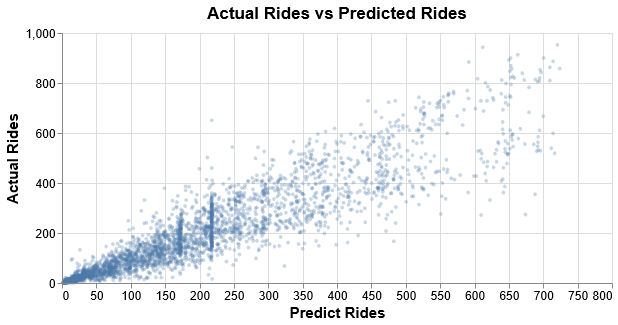

In [20]:
chart = alt.Chart(data_combine_rf).mark_point(opacity=0.3, size = 4).encode(
            alt.X('y_predict:Q', title = 'Predict Rides'),
            alt.Y('y_true_test:Q', title = 'Actual Rides')
        ).properties(title="Actual Rides vs Predicted Rides",
                    width=550, height=250, background='white').configure_axisX(labelFontSize=12,
    titleFontSize=15).configure_axisY(labelFontSize=12,
    titleFontSize=15).configure_title(fontSize=17)
chart

In [102]:
chart.save("fig_result.png", scale_factor=5.0)

In [ ]:
data_result.reset_index(inplace = True)

In [94]:
data_result.to_csv("result.csv", index=False)

In [31]:
data_result

,index,Model,Train Error,Test Error,Best Parameters
0,0,LinearRegression,147.905771,145.607463,{'normalize': False}
1,0,KNN,72.186130,78.425653,{'n_neighbors': 15}
2,0,RandomForest,63.914044,70.817688,"{'max_depth': 10, 'n_estimators': 100}"


In [35]:
data_result.loc[2,"Best Parameters"]

"{'max_depth': 10, 'n_estimators': 100}"

In [37]:
import ast
res = ast.literal_eval(data_result.loc[2,"Best Parameters"])

In [39]:
res['max_depth']

10

In [40]:
model = RandomForestRegressor(max_depth = res['max_depth'], n_estimators = res['n_estimators'])
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
data_importance = pd.DataFrame({"Features":X_train.columns, "Feature Importance":model.feature_importances_})

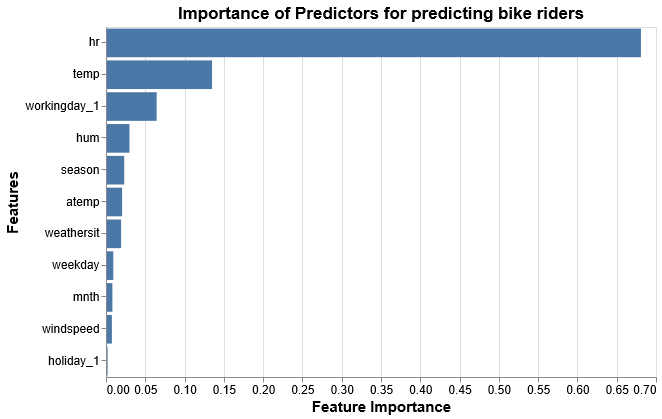

In [64]:
chart1 = alt.Chart(data_importance).mark_bar().encode(
    x=alt.X('Feature Importance:Q'),
    y=alt.Y('Features:O', sort=alt.EncodingSortField(field="Feature Importance", op="sum", order='descending'))
).properties(title="Importance of Predictors for predicting bike riders",
                    width=550, height=350, background='white').configure_axisX(labelFontSize=12,
    titleFontSize=15).configure_axisY(labelFontSize=12,
    titleFontSize=15).configure_title(fontSize=17)

chart1